# A/B Testing Review

A/B testing is the simplest form of a randomized controlled experiment used to compare two versions of something to figure out which performs better. A simple workflow is as follows:

**1. Define the Research Question**

    What decision are you trying to inform? (e.g., “Will incentive emails improve survey response rate?”)

**2. Formulate the Hypotheses**

    Null Hypothesis (H₀): There is no difference between the two versions

    Alternative Hypothesis (H₁): There is a significant difference between the versions

**3. Design the Experiment**

    Define control and treatment groups

**4. Random Assignment of Units**

    Ensure groups are comparable

    Use randomization tools to avoid selection bias

**5. Define Outcome Metric(s)**

    Primary metric: Conversion, revenue, response rate, etc.

**6. Analyze Results Using Appropriate Statistical Tests**

    Check assumptions (normality, variance, sample size)

**7. Interpret Results and Make a Decision**

    Compare p-value or confidence intervals

    Decide whether to reject H₀








## Examples of A/B testing
1. Company: E-commerce company

   Test: Change the color of the "Add to Cart" button (e.g., yellow vs. green).

   Goal: Increase click-through rate on the button.

   Outcome Measured: percentage of users who clicked "Add to Cart."



2. Company: Airbnb

   Test: “Find Your Next Getaway” vs. “Ready for a Summer Escape?”

   Goal: Maximize email open rates.

   Outcome Measured: Open rate, click-through rate on links inside the email.


3. Example: Online learning company

   Test: Hints auto-enabled vs. hints disabled by default.

   Goal: Improve learning outcomes.

   Outcome Measured: Problem-solving accuracy, time on task, course completion.

**Which test should I use?**

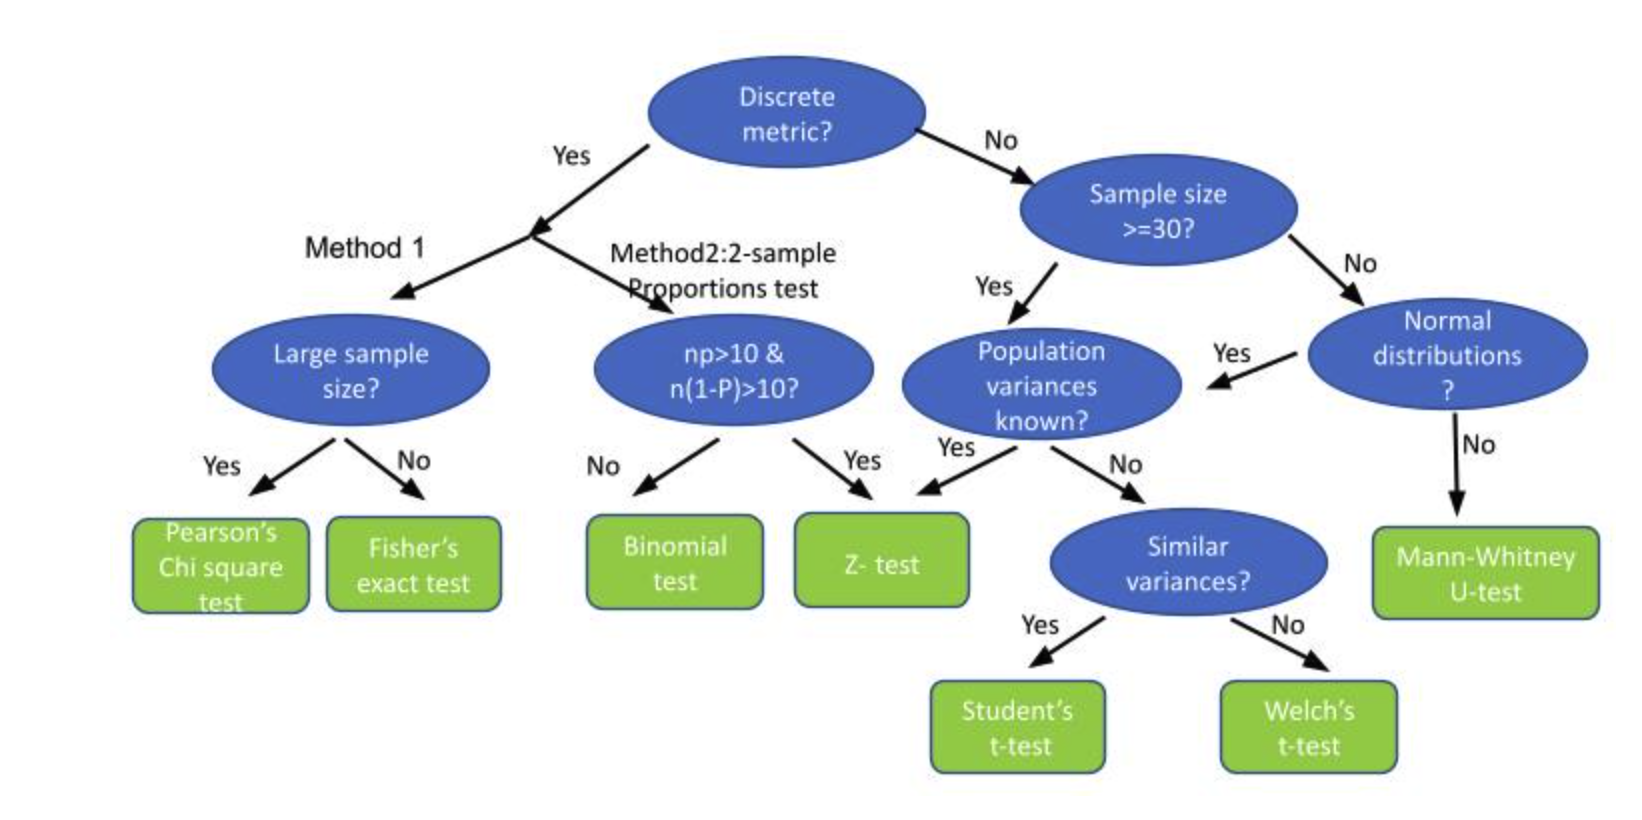

In [1]:
from IPython.display import Image, display

display(Image(filename='figure1.png', width=500))


**Discrete metrics VS.continuous metrics**

**1. Discrete metrics** also called binomial metrics, have only two values 0 and 1, such as click-through rate, conversion rate, bounce rate.

**2. continuous metrics,** also called non-binomial metrics, can take continuous values that are not limited to 0 and 1, such as average revenue, average session duration for a custormer stay on a website,  average order value for the custormers.


**One-tailed test VS. two-tailed test**

The choice of one-tailed test or two-tailed test depends on the original claim in the question. A one-tailed test looks for an “increase” or “decrease” (>,<are used in H1), whereas a two-tailed test looks for a “change”(≠is used in H1).

** Please find the dataset for this notebook here**

https://drive.google.com/file/d/1Xb5tiO8sYBXC55PEwhUw_kvwe96SeqsI/view?usp=drive_link

In [2]:
import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import shapiro

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import display, Math

from statsmodels.stats.proportion import proportions_ztest

**1. E-commerce web designer**
(A conversion in E-commerce context refers to a customer completing a desired action that has business value (e.g. making a purchase, add to shopping cart))

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Q1: Why randomization?
1. Ensure groups are comparable
2. Avoid selection bias
3. Rule out alternative explanations (i.e., control all the other variables), so that we can attribute any observed effect to the cause

In [4]:
# Data Cleaning
# Locate rows of duplicate data
dups = df.duplicated()
print(dups.any())

False


In [5]:
# Check duplicate user_id
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [6]:
# Check if there is mismatch between group and landing_page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows:{n_mismatch} rows" )
print("Percent of mismatched rows:%.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows:3893 rows
Percent of mismatched rows:1.32%


 As you can see, there are 3893 rows mismatched, which means that treatment group mismatched with old_page and control group mismatched with new_page.There are also 3895 duplicated user_id, some of them loading both new page and old page. This might be the relative department repeat the expermient after finding the mismatched problem. Therefore, we need to only keep the right data and drop the mismatched data.   

In [7]:
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]

## Q2: What is your outcome metric?

The outcome metric is the Conversion Rate, which measures the proportion of users who completed the desired action (i.e., converted = 1) among the total number of users in each group. 

This metric directly reflects whether the new landing page design is effective in driving user conversion.


In [8]:
# Conversion Rate
display(Math(r'\text{Conversion Rate} = \frac{\text{Number of Converted Users}}{\text{Total Number of Users}} \times 100\%'))

<IPython.core.display.Math object>

In [9]:
df_conversion = pd.DataFrame({
    "Control_Conversion_Rate": [df2[df2.group == "control"]['converted'].mean()],
    "Treatment_Conversion_Rate": [df2[df2.group == "treatment"]['converted'].mean()]
})
df_conversion

,Control_Conversion_Rate,Treatment_Conversion_Rate
0,0.120386,0.118807


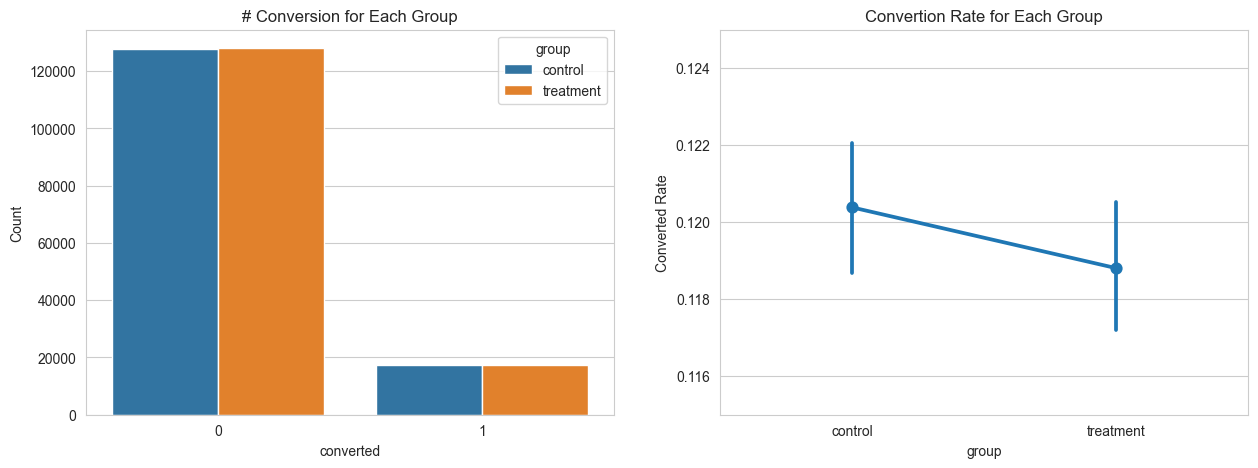

In [10]:
fig, axes = plt.subplots(1,2)

sns.countplot(x="converted", data=df2, hue="group", ax=axes[0])
axes[0].set(title="# Conversion for Each Group", ylabel="Count")

sns.pointplot(x="group", y="converted", data=df2, ax=axes[1])
axes[1].set_ylim([0.115, 0.125])
axes[1].set(title="Convertion Rate for Each Group",ylabel="Converted Rate")

plt.show()

## Q3: What are your hypothesis?

H0: There is no difference in the conversion rates between the Control and Treatment groups.

H1: There is a significant difference in the conversion rates between the Control and Treatment groups. 

In [11]:
print('Control group:')
print('np:', len(df2[df2.group == "control"]['converted'])*0.120386)
print('n(1−p):', len(df2[df2.group == "control"]['converted'])*(1-0.120386))
print('Treatment group:')
print('np:', len(df2[df2.group == "treatment"]['converted'])*0.118807)
print('n(1−p):', len(df2[df2.group == "treatment"]['converted'])*(1-0.118807))

Control group:
np: 17488.955764000002
n(1−p): 127785.044236
Treatment group:
np: 17263.963977
n(1−p): 128047.03602300001


## Q4: What statistical test would you use and why?

Based on figure 1, we can see that we can use Chi square test and Z-test.

For Chi square test, here is Discrete metric, and it satisfies Large sample.

For Z-test, it satisfies np>10 & n(1-p)>10. The specific results are as follows:

Control group:

np: 17489

n(1−p): 127785

Treatment group:

np: 17264

n(1−p): 128047


In [12]:
table = pd.DataFrame({"Control_COUNT": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df2[df2.group=="treatment"].converted.value_counts()})

stat, p, dof, expected = stats.chi2_contingency(table)
print("fredoom of degree=%d"% dof)
print(expected)


fredoom of degree=1
[[127899.7125385 127932.2874615]
 [ 17374.2874615  17378.7125385]]


## Q5: How would you interpret the results?

Based on the results of Chi-square test (p=0.192 > 0.05)  and Z-test (p=0.190 > 0.05), we fail to reject the null hypothesis (H0) at the 0.05 significance level.

In other words, there is no difference in the conversion rates between the Control and Treatment groups.


In [13]:
# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
# interpret p-value
alpha = 1-prob
print('Chi square test: significance=%.3f, p=%.3f' % (alpha, p))

Chi square test: significance=0.050, p=0.192


In [14]:
control_converted = df2[(df2.group == 'control')]['converted'].sum()
treatment_converted = df2[(df2.group == 'treatment')]['converted'].sum()

control_total = df2[df2.group == 'control'].shape[0]
treatment_total = df2[df2.group == 'treatment'].shape[0]

count = np.array([control_converted, treatment_converted]) 
nobs = np.array([control_total, treatment_total]) 

stat, p = proportions_ztest(count, nobs)

print('Z-test: significance=%.3f, p=%.3f' % (alpha, p))

Z-test: significance=0.050, p=0.190


# More complex examples
In the real world problem, we may face more complex tests, like mutigroups pairwise tests, mutifactors tests.

Here is an example of One-Way ANOVA test for one factor and mutiple groups testing

In [15]:
df_group3 = pd.DataFrame({"score": [87, 86, 88, 75, 78, 94, 98, 79, 71, 69,
                             91, 92, 90, 90, 97, 94, 82, 88, 95, 96,
                             88, 78, 88, 94, 93, 85, 83, 85, 82, 81],
                   "group": np.repeat(["A", "B", "C"], repeats=10)})
A = df_group3[df_group3["group"]=="A"].score
B = df_group3[df_group3["group"]=="B"].score
C = df_group3[df_group3["group"]=="C"].score

In [16]:
# Perform one-way ANOVA
stats.f_oneway(A, B, C)

F_onewayResult(statistic=4.491727279993608, pvalue=0.020702475181623638)

If the overall p-value from the ANOVA table is less than some significance level, then we have sufficient evidence to say that at least one of the means of the groups is different from the others.This method doesn’t tell us which groups are different from each other. We must conduct a post hoc test.

In [17]:
#Post-hoc tests for multiple pairwise comparisons (https://www.statology.org/tukey-vs-bonferroni-vs-scheffe/)
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_group3['score'],
                          groups=df_group3['group'],
                          alpha=0.05)

#display results
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B      9.0  0.017   1.4521 16.5479   True
     A      C      3.2 0.5519  -4.3479 10.7479  False
     B      C     -5.8 0.1566 -13.3479  1.7479  False
-----------------------------------------------------


We would conclude that there is a statistically significant difference between the means of groups a and b, but not a statistically significant difference between the means of groups a and c, and groups b and c.

# Conclusion
While A/B testing is a powerful and widely used method for evaluating changes in user experience, marketing, or product design, real-world applications often involve complexities that go beyond simple two-group comparisons. In practice, factors such as user heterogeneity, time-based effects, and competing experiments (multiple A/B testings are running at the same time) can all influence results and interpretations. Moreover, running an A/B test ethically and effectively requires careful attention to randomization, sample size, metric selection, and statistical assumptions. As organizations increasingly rely on data to guide decisions, understanding not just how to run an A/B test, but also how to adapt its design to complex, dynamic environments is essential for drawing meaningful and actionable conclusions.

## NOTE
The activity is adpated from https://www.kaggle.com/code/janiezj/a-b-testing-examples-from-easy-to-advanced. Feel free to check more detials by clicking the link.